# 🧠 02_entrenamiento_modelo.ipynb

Este notebook entrena un modelo de aprendizaje profundo (Deep Learning) para reconocer letras del lenguaje de señas usando los *landmarks* generados por MediaPipe.

## 🔄 Etapas del notebook:
1. Importar librerías
2. Cargar los datos limpios
3. Separar características y etiquetas
4. Codificar las etiquetas
5. Dividir el dataset en entrenamiento y prueba
6. Normalizar los datos
7. Crear el modelo neuronal
8. Compilar el modelo
9. Entrenar el modelo
10. Visualizar resultados


## 🧩 1️⃣ Importar librerías

Importamos todas las librerías necesarias para el manejo de datos, construcción del modelo y visualización de resultados.

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

Si hay errores con tensorflow, desistale estas dependencias y vuelva a instalar


pip install numpy==1.24.3
pip install tensorflow==2.15.0
pip install opencv-python==4.8.1.78 opencv-contrib-python==4.8.1.78

In [ ]:
import tensorflow as tf
import mediapipe as mp
import cv2
import numpy as np

print("TensorFlow:", tf.__version__)
print("MediaPipe:", mp.__version__)
print("OpenCV:", cv2.__version__)
print("NumPy:", np.__version__)

## 🧹 2️⃣ Cargar los datos limpios

Cargamos el dataset que fue previamente limpiado en el notebook `01_limpieza_datos.ipynb`. Este archivo contiene los landmarks de las manos normalizados y una columna con la etiqueta (letra).

In [6]:
PROCESSED_DIR = "../dataset_landmarks_limpios"   # <<== ajusta aquí si hace falta

X_train = np.load(f"{PROCESSED_DIR}/X_train.npy")
y_train = np.load(f"{PROCESSED_DIR}/y_train.npy")
X_val   = np.load(f"{PROCESSED_DIR}/X_val.npy")
y_val   = np.load(f"{PROCESSED_DIR}/y_val.npy")
X_test  = np.load(f"{PROCESSED_DIR}/X_test.npy")
y_test  = np.load(f"{PROCESSED_DIR}/y_test.npy")

# Si tienes label2id.json
import json
with open(f"{PROCESSED_DIR}/label2id.json","r") as f:
    label2id = json.load(f)
id2label = {int(v):k for k,v in label2id.items()}

print("Shapes:")
print(" X_train:", X_train.shape)
print(" y_train:", y_train.shape)
print(" X_val:  ", X_val.shape)
print(" y_val:  ", y_val.shape)
print(" X_test: ", X_test.shape)
print(" y_test: ", y_test.shape)
print("Num classes:", len(label2id))


Shapes:
 X_train: (32302, 63)
 y_train: (32302,)
 X_val:   (6922, 63)
 y_val:   (6922,)
 X_test:  (6923, 63)
 y_test:  (6923,)
Num classes: 24


In [7]:
# Si y_train es vector de enteros -> one-hot
if y_train.ndim == 1 or (y_train.ndim == 2 and y_train.shape[1] == 1):
    num_classes = len(label2id)
    y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_ohe   = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_ohe  = tf.keras.utils.to_categorical(y_test, num_classes)
else:
    # Si ya están en one-hot:
    y_train_ohe = y_train
    y_val_ohe   = y_val
    y_test_ohe  = y_test
    num_classes = y_train_ohe.shape[1]

print("y_train_ohe shape:", y_train_ohe.shape)


y_train_ohe shape: (32302, 24)


In [8]:
input_dim = X_train.shape[1]
model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train_ohe,
    validation_data=(X_val, y_val_ohe),
    epochs=50,
    batch_size=64,
    verbose=2
)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               16384     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 52376 (204.59 KB)
Trainable params: 52376 (204.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


505

Test loss: 0.0043738167732954025    Test accuracy: 0.998699963092804
217/217 [==============================] - 0s 997us/step
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       146
          10       1.00      1.00      1.00       402
           2       1.00      1.00      1.00       148
           4       1.00      0.96      0.98       150
           5       1.00      1.00      1.00       148
           7       1.00      1.00      1.00       150
           8       1.00      1.00      1.00       214
           A       1.00      1.00      1.00       293
           B       0.99      1.00      0.99       455
           C       1.00      1.00      1.00       301
           D       1.00      1.00      1.00       296
           E       1.00      1.00      1.00       320
           F       0.99      1.00      0.99       297
           I       1.00      1.00      1.00       330
           K       1.00      1.00      1.00       585
         

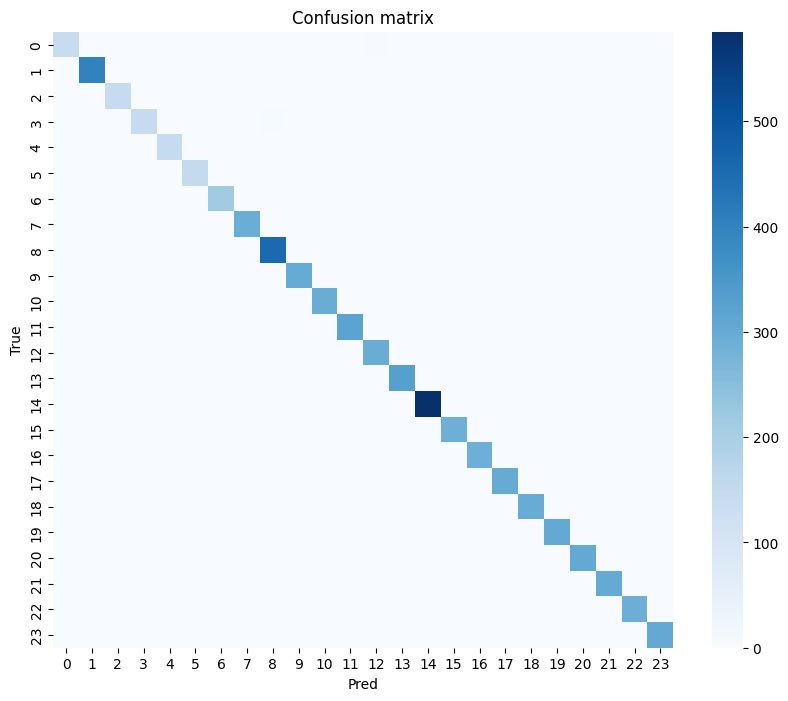

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Eval
loss, acc = model.evaluate(X_test, y_test_ohe, verbose=0)
print("Test loss:", loss, "   Test accuracy:", acc)

# Predicciones
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(num_classes)]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues')
plt.title("Confusion matrix")
plt.xlabel("Pred")
plt.ylabel("True")
plt.show()
